# Spark Streaming
At a high level, stream processing is about the continuous processing of unbounded
streams of data. 
> **stream processing engines**: Spark, Flink, Samza, Heron and Kafka 

**Batch Data Processing** applies to a fixed size and static input dataset, the processing ends when the end of the dataset is reached. Produces one result at the end. <br>

**Stream Processing**: is about running the
computational logic through unbounded streams of data, and therefore the processing
is continuous and long-running.

<mark>one common practice in the stream processing engines is to divide the incoming
data into chunks by using the start and end time as the boundary. </mark>

## Windowing
> Hence, to extract any meaningful value from the incoming
data, you must process them in chunks. For example, given a traffic count sensor that
emits a count of the number of cars every 20 seconds, it is not feasible to compute a final
sum. Instead, it is more logical to ask how many cars pass that sensor every minute or
five minutes. In this case, you need to partition the traffic counting data into chunks of 1
minute or 5 minutes, respectively. Each chunk is called a window.

Windowing is a common stream processing pattern where the unbounded coming
streaming of data is divided into chunks based on temporal boundaries
### There are three commonly used windowing patterns
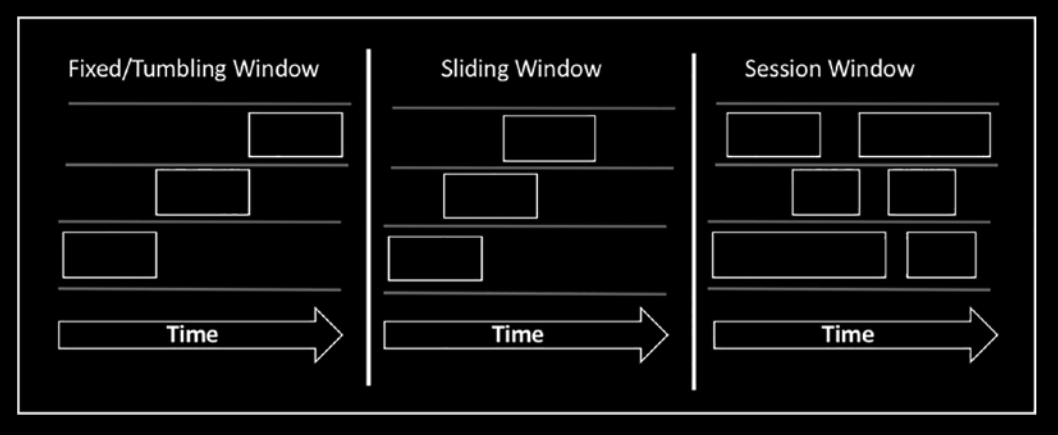

* Fixed/tumbling window divides the incoming stream of data into fixed-size
segments, where each one has a window length, a start time, and an end time. Each
coming piece of data is slotted into one and only one fixed/tumbling window. 
* Sliding Window: Figure 6-4 shows the sliding interval is smaller than the window
length. This implies that one or more pieces of data are included in more than one
sliding window. 
* The session window type is commonly used to analyze user behavior on a website.

|||
|---|---|
|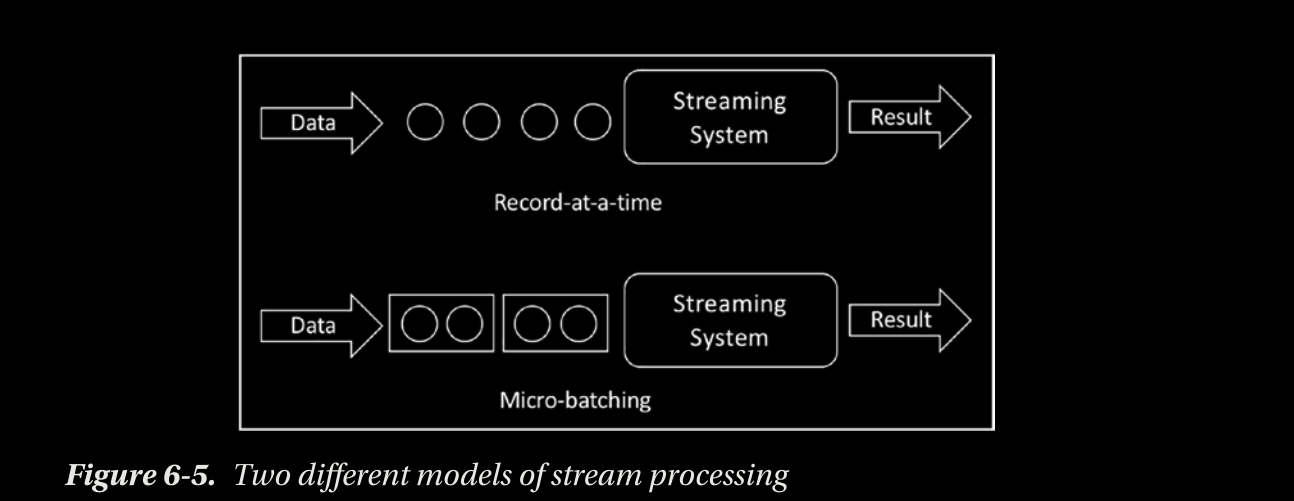|* The record-at-a-time model,  this model can provide low latency in milliseconds. <br>* The micro-batching model waits and accumulates a small batch of input data based on a configurable batching interval and processes each batch in parallel. The throughput is higher |

# Spark Streaming Overview
* Spark’s first-generation stream processing engine called DStream. (now historical)
* Spark’s second stream processing engine called Structured Streaming.

## Spark Structured Streaming
<mark>It was designed to be much faster, more scalable, and more fault-tolerant and address the shortcomings in
the first-generation streaming engine. </mark>

> to react to data in real-time using a simple programming model


|||
|---|---|
|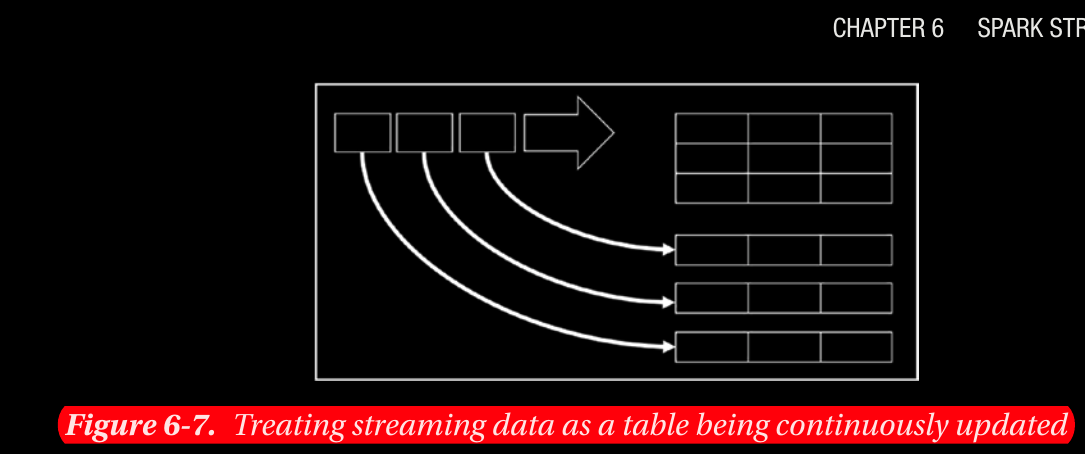|Another way of thinking of a stream of incoming data is as nothing more than a table being continuously appended. The Structured Streaming engine takes care of running them incrementally and continuously as new streaming data arrives. |




## Core Concepts
---
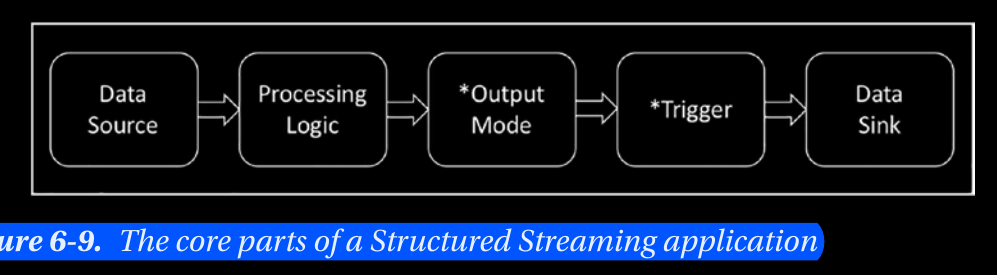

* **Data Sources:** From where you are going to get the data. They generate the data continuously,
and the rate can vary over time. Structured Streaming provides native support for the
following sources.
    * Kafka Source: most commond, requires special set up
    * File Source: As new files are dropped into a directory, this data source picks them up for processing. Commonly used file formats are supported, such as text, CSV, JSON, ORC, and Parquet. 
    * Socket Source: host + port
    * Rate Source: prebuit, generates data randomly
* **Output Modes**: Output modes are a way to tell Structured Streaming how the output data should be written to a sink. This concept is unique to stream processing in Spark. There are three options.
    * Append mode: This is the default mode if the output mode is not specified. In this mode, only the new rows appended to the resulting table are sent to the specified output sink.
    * Complete mode: The entire resulting table is written to the output sink.
    * Update mode: Only the updated rows in the resulting table are written to the output sink. This means unchanged rows are not written out.

* **Trigger Types**: The trigger is another important concept to understand. The Structured Streaming engine uses the trigger information to determine when to execute the provided streaming computation logic on the newly discovered streaming data.


| Type                    | Description                                                                                                                                                                                                                                     |
|-------------------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Not specified (default) | For this default type, Spark uses the micro-batch mode and processes the next batch of data as soon as the previous batch of data has completed processing.                                                                                      |
| Fixed interval          | For this type, Spark uses the micro-batch mode and processes the batch of data based on the user-provided interval. If the processing of the previous batch of data takes longer than the interval, then the next batch of data is processed immediately after the previous one is completed. In other words, Spark does not wait until the next interval boundary. |
| One-time                | This trigger type is meant to be used for one-time processing of the available batch of data, and Spark immediately stops the streaming application once the processing is completed. This trigger type is useful when the data volume is extremely low, and therefore it is more cost effective to spin up a cluster and process the data only a few times a day.               |
| Continuous              | Spark executes your streaming application logic using the new low latency and continuous processing mode.                                                                                                                                       |

* **Data Sinks**:  They are meant for storing the output of streaming applications
    * kafka Sink: requires special config
    * File sink: This is a destination on a file system, HDFS, or S3
    * Foreach sink: This is meant for running an arbitrary computation on the rows in the output.
    * Console sink: This is for testing and debugging purposes only and when working with low volume data. The output is printed out to the console on every trigger.
    * Memory sink: This is for testing and debugging purposes only when working with low-volume data. It uses the memory of the driver to store the output.

* **Watermarking**: Structured Streaming uses the specified threshold to determine <mark>when</mark> the old state can be discarded.

# First Example

In [1]:
from pyspark.sql import SparkSession
import os
import pyspark.sql.functions as F
import pyspark.sql.types as T
from pyspark.sql.window import Window

spark = SparkSession.builder.appName("SQL").getOrCreate()

24/06/28 14:17:27 WARN Utils: Your hostname, msi-MAG resolves to a loopback address: 127.0.1.1; using 192.168.0.129 instead (on interface wlp3s0)
24/06/28 14:17:27 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/06/28 14:17:27 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


> By default, Structured Streaming requires a schema when reading data from a file-­based data source

In [4]:
path = "/home/msi/local_projects/beginning-apache-spark-3/chapter6/data/mobile"

there are 3 separate csv files on the folder `mobile`

Lets see the contect of the folder mobile

In [5]:
mobileDataDF = spark.read.json(path)

In [7]:
print(mobileDataDF.printSchema())

mobileDataDF.show()

root
 |-- action: string (nullable = true)
 |-- id: string (nullable = true)
 |-- ts: string (nullable = true)

None
+------+------+-------------------+
|action|    id|                 ts|
+------+------+-------------------+
|  open|phone1|2018-03-02T10:02:33|
|  open|phone2|2018-03-02T10:03:35|
|  open|phone3|2018-03-02T10:03:50|
| close|phone1|2018-03-02T10:04:35|
| crash|phone2|2018-03-02T11:09:13|
| swipe|phone5|2018-03-02T11:17:29|
| close|phone3|2018-03-02T10:07:35|
|  open|phone4|2018-03-02T10:07:50|
| close|phone2|2018-03-02T10:04:50|
|  open|phone5|2018-03-02T10:10:50|
+------+------+-------------------+



> unfortunately, python automatically merged all files into one df, but there are 3 files, 
we are going to simulate a streaming event by copy and paste, one by one these files into a folder called `input` 

## Straming DataFrame
lets create a Streaming DataFrame

In [8]:
# schema for the data
mobileDataSchema = "`id` String, `action` String, `ts` Timestamp"

In [9]:
# there is no input folder, (I create a empty one)
# (schema must be provided - you cannot infer a schema of a empty dir)
mobileSSDF = spark.readStream.schema(mobileDataSchema).json("./input/")

#check whether is a Streaming DF
mobileSSDF.isStreaming

True

## Straming Action

In [10]:
#  perform a group by using event time of column ts and fixed window of 10 mins
actionCountDF = mobileSSDF.groupBy(F.window(F.col("ts"),"10 minutes"), F.col("action")).count()

## Listening
> The **start()** function triggers the Spark Structured Streaming engine
to *start watching the input folder and start processing the data once it sees new files in
that folder*. **After copying** the file1.json file from the `chapter6/data/mobile` directory
to the `chapter6/data/input` directory, the output console displays the output 

In [11]:
# start the streaming query and write the output to console
mobileConsoleSQ = actionCountDF.writeStream\
    .format("console").option("truncate", "false")\
    .outputMode("complete").start()

24/06/28 14:58:14 WARN ResolveWriteToStream: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-fdb6246a-a1b0-42f9-a9d3-d99b03bbc037. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.
24/06/28 14:58:14 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.


-------------------------------------------
Batch: 0
-------------------------------------------
+------------------------------------------+------+-----+
|window                                    |action|count|
+------------------------------------------+------+-----+
|{2018-03-02 10:00:00, 2018-03-02 10:10:00}|close |1    |
|{2018-03-02 10:00:00, 2018-03-02 10:10:00}|open  |3    |
+------------------------------------------+------+-----+



-------------------------------------------
Batch: 1
-------------------------------------------
+------------------------------------------+------+-----+
|window                                    |action|count|
+------------------------------------------+------+-----+
|{2018-03-02 10:00:00, 2018-03-02 10:10:00}|close |2    |
|{2018-03-02 10:00:00, 2018-03-02 10:10:00}|open  |4    |
+------------------------------------------+------+-----+

-------------------------------------------
Batch: 2
-------------------------------------------
+------------------------------------------+------+-----+
|window                                    |action|count|
+------------------------------------------+------+-----+
|{2018-03-02 10:10:00, 2018-03-02 10:20:00}|open  |1    |
|{2018-03-02 10:00:00, 2018-03-02 10:10:00}|close |3    |
|{2018-03-02 10:00:00, 2018-03-02 10:10:00}|open  |4    |
+------------------------------------------+------+-----+



Look at the copy and paste
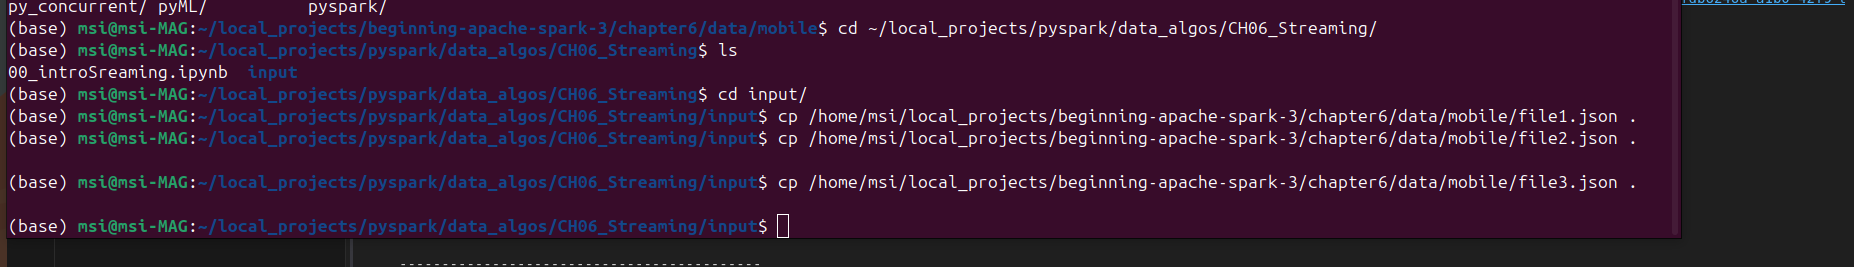

file3.json contains one close action that belongs to the first window
and an open action that falls into a new window from 10:10 to 10:20

**now I'm parallel run the command** <br>
`cp file1.json ../input/` <br>
`cp file2.json ../input/` <br>
`cp file3.json ../input/` <br>



> **batch 0** <br>
> `file1.json` The output indicates there is only one window from 10:00 to 10:10, and within this
window, there are one close action and three open actions <br>
> **batch 1** <br>
> `file2.json` data file contains one event with open
action and another with close action and both fall in the same window [10:00 - 10:10) Therefore, the
counts are updated <br>
> **batch 2** <br>
> `file3.json` contains one close action that belongs to the first window
and an open action that falls into a new window from 10:10 to 10:20.  <br>

In [13]:
mobileConsoleSQ.status

{'message': 'Waiting for data to arrive',
 'isDataAvailable': False,
 'isTriggerActive': False}

In [14]:
mobileConsoleSQ.lastProgress

{'id': '375c711e-6d82-4b64-9f2e-aba569064bb2',
 'runId': '5f7a4bc4-3210-4d17-a1de-650c04bf9680',
 'name': None,
 'timestamp': '2024-06-28T13:18:09.097Z',
 'batchId': 3,
 'numInputRows': 0,
 'inputRowsPerSecond': 0.0,
 'processedRowsPerSecond': 0.0,
 'durationMs': {'latestOffset': 1, 'triggerExecution': 1},
 'stateOperators': [{'operatorName': 'stateStoreSave',
   'numRowsTotal': 3,
   'numRowsUpdated': 0,
   'allUpdatesTimeMs': 48,
   'numRowsRemoved': 0,
   'allRemovalsTimeMs': 0,
   'commitTimeMs': 7111,
   'memoryUsedBytes': 87184,
   'numRowsDroppedByWatermark': 0,
   'numShufflePartitions': 200,
   'numStateStoreInstances': 200,
   'customMetrics': {'loadedMapCacheHitCount': 800,
    'loadedMapCacheMissCount': 0,
    'stateOnCurrentVersionSizeBytes': 21448}}],
 'sources': [{'description': 'FileStreamSource[file:/home/msi/local_projects/pyspark/data_algos/CH06_Streaming/input]',
   'startOffset': {'logOffset': 2},
   'endOffset': {'logOffset': 2},
   'latestOffset': None,
   'numIn

In a production and long-running streaming application, it is required to call the
<mark>StreamingQuery.awaitTermination()</mark> function. It is a blocking call to prevent the
main thread process from exiting and enable the streaming query to continuously run
and process new data as they arrive into the data source. 

In [15]:
DO NOT RUN!
# this is blocking call
mobileConsoleSQ.awaitTermination()

ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/home/msi/anaconda3/lib/python3.11/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/msi/anaconda3/lib/python3.11/site-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
                          ^^^^^^^^^^^^^^^^^^^^^^
  File "/home/msi/anaconda3/lib/python3.11/socket.py", line 706, in readinto
    return self._sock.recv_into(b)
           ^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt


KeyboardInterrupt: 

### Closing Streaming
You can use the **StreamingQuery.stop()** function to stop the data source from receiving new data and
stop the ­continuous execution of logic in a streaming query.

In [ ]:

# stop a streaming query
mobileConsoleSQ.stop()

In [ ]:
#DO NOT RUN
# another way to stop all streaming queries in a Spark application
for qs in spark.streams.active: 
    print(f"Stop streaming query: {qs.name} - active:{qs.isActive}")
    if (qs.isActive):
        qs.stop()

# Part 2: Streaming DataFrame Operations
--- 

the DataStreamReader returns an instance of a DataFrame, this means  you can use most operations
and Spark SQL functions to express your application’s streaming computation
logic, <br>

NOT ALL FUNCTIONS ARE SUPPORTED <br>
Examples of such operations include limit, distinct, cube, and sort.

### Filtering

In [19]:
mobileDataDF.filter((F.col("action") == "open") | (F.col("action") == "close"))\
.select("id", F.upper(F.col("action")), "ts").show()

+------+-------------+-------------------+
|    id|upper(action)|                 ts|
+------+-------------+-------------------+
|phone1|         OPEN|2018-03-02T10:02:33|
|phone2|         OPEN|2018-03-02T10:03:35|
|phone3|         OPEN|2018-03-02T10:03:50|
|phone1|        CLOSE|2018-03-02T10:04:35|
|phone3|        CLOSE|2018-03-02T10:07:35|
|phone4|         OPEN|2018-03-02T10:07:50|
|phone2|        CLOSE|2018-03-02T10:04:50|
|phone5|         OPEN|2018-03-02T10:10:50|
+------+-------------+-------------------+



In [17]:
mobileDataDF.filter((F.col("action") == "open"))\
.select("id", F.upper(F.col("action")), "ts").show()

+------+-------------+-------------------+
|    id|upper(action)|                 ts|
+------+-------------+-------------------+
|phone1|         OPEN|2018-03-02T10:02:33|
|phone2|         OPEN|2018-03-02T10:03:35|
|phone3|         OPEN|2018-03-02T10:03:50|
|phone4|         OPEN|2018-03-02T10:07:50|
|phone5|         OPEN|2018-03-02T10:10:50|
+------+-------------+-------------------+



> **try to apply it to the streaming df**

In [33]:
#  perform a filter using event time of column ts and fixed window of 10 mins
cleanMobileSSDF = mobileSSDF.filter((F.col("action") == "open")).select("id", F.upper(F.col("action")).alias("action"), "ts")

# start the streaming query and write the output to console
mobileConsoleSQ = cleanMobileSSDF.writeStream\
    .format("console")\
    .option("truncate", "false")\
    .outputMode("append")\
    .start()

# look at the outputmode

24/06/28 15:53:14 WARN ResolveWriteToStream: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-42358509-4d49-40fe-bd41-679c3d715f4b. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.
24/06/28 15:53:14 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.


-------------------------------------------
Batch: 0
-------------------------------------------
+------+------+-------------------+
|id    |action|ts                 |
+------+------+-------------------+
|phone1|OPEN  |2018-03-02 10:02:33|
|phone2|OPEN  |2018-03-02 10:03:35|
|phone3|OPEN  |2018-03-02 10:03:50|
|phone4|OPEN  |2018-03-02 10:07:50|
|phone5|OPEN  |2018-03-02 10:10:50|
+------+------+-------------------+

-------------------------------------------
Batch: 1
-------------------------------------------
-------------------------------------------
Batch: 1
-------------------------------------------
+------+------+-------------------+
|id    |action|ts                 |
+------+------+-------------------+
|phone5|OPEN  |2018-03-02 10:10:50|
+------+------+-------------------+

-------------------------------------------
Batch: 1
-------------------------------------------
+------+------+-------------------+
|id    |action|ts                 |
+------+------+-------------------

-------------------------------------------
Batch: 1
-------------------------------------------
+------------------------------------------+------+-----+
|window                                    |action|count|
+------------------------------------------+------+-----+
|{2018-03-02 10:10:00, 2018-03-02 10:20:00}|open  |2    |
|{2018-03-02 10:00:00, 2018-03-02 10:10:00}|close |4    |
|{2018-03-02 10:00:00, 2018-03-02 10:10:00}|open  |4    |
+------------------------------------------+------+-----+

-------------------------------------------
Batch: 3
-------------------------------------------
+------------------------------------------+------+-----+
|window                                    |action|count|
+------------------------------------------+------+-----+
|{2018-03-02 10:10:00, 2018-03-02 10:20:00}|open  |2    |
|{2018-03-02 10:00:00, 2018-03-02 10:10:00}|close |4    |
|{2018-03-02 10:00:00, 2018-03-02 10:10:00}|open  |4    |
+------------------------------------------+------+

> Since you don't want to use complete mode and you are not performing any aggregations, append and update are your two options. append mode will output only the new rows added to the result table since the last trigger,

ANOTHE APPROACH: Create a View

In [32]:
# create a view to apply SQL queries on
cleanMobileSSDF.createOrReplaceTempView("clean_mobile")
spark.sql("select * from clean_mobile")

DataFrame[id: string, action: string, ts: timestamp]

> the following DataFrame transformations are not supported yet in a streaming DataFrame
> * Multiple aggregations or a chain of aggregations on a streaming
DataFrame
> * Limit and take N rows
> * Distinct transformation (There is a way to deduplicate data using a
unique identifier, however.)
> * Sorting on a streaming DataFrame without any aggregation (sorting
is supported after some form of aggregation, however.)

# JOIN

Example

In [ ]:
from pyspark.sql.functions import expr
# the specific streaming data source information is not important in this example
tempDataDF = spark.readStream. ...
loadDataDF = spark.readStream. ...

tempDataWatermarkDF = tempDataDF.withWaterMark("temp_taken_time","1 hour")
loadDataWatermarkDF = loadDataDF.withWaterMark("load_taken_time","2 hours")

# join on the location id as well as the event time constraint
tempWithLoadDataDF = tempDataWatermarkDF.join(loadDataWatermarkDF,
expr(""" temp_location_id = load_location_id AND
load_taken_time >= temp_taken_time AND
load_taken_time <= temp_taken_time + interval 1 hour
""")
)

One of the coolest things you can do with a streaming DataFrame is to join it with either
a **static DataFrame** or another **streaming DataFrame**. 

Depending the type of df this are the supported join_types

| Left Side+Right Side  | Join Type   | Note                                                                       |
|-----------------------|-------------|----------------------------------------------------------------------------|
| Static+Streaming      | Inner       | Supported                                                                  |
| Static+Streaming      | Left Outer  | Not supported                                                              |
| Static+Streaming      | Right Outer | Supported                                                                  |
| Static+Streaming      | Full Outer  | Not supported                                                              |
| Streaming+Streaming   | Inner       | Supported                                                                  |
| Streaming+Streaming   | Left Outer  | Conditionally supported. Must specify watermark on right side and time constraint  |
| Streaming+Streaming   | Right Outer | Conditionally supported. Must specify watermark on left side and time constraint   |
| Streaming+Streaming   | Full Outer  | Not supported                                                              |


### WaterMark
How long data has to be keeped?

> **Steaming dataframe have no defined size so... how do you join them?** <br>
> you have to give one to it? generally a time-bounded-size, this is called `WaterMark` 
> it tells the machine to preserve the data during X time (so joins can be performed with this DF)

>    `withWatermark("temp_taken_time", "1 hour")` tells Spark that it should retain the state for up to 1 hour beyond the maximum event time seen so far. <br>
>   This means Spark will allow data that arrives up to 1 hour late to be included in the aggregations.